In [3]:
import pandas as pd
import numpy as np
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
from IPython import embed
import itertools
import os
import datetime
import csv
import time
from multiprocessing import Pool, cpu_count
p = Pool(processes=2)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 共通関数部

In [5]:
class CommonFunctions():
    def comb_index(self, n1, n2):
        #-----------------------
        # 組み合わせ番号から2つの組み合わせのインデックスを返す
        #  n1: 組み合わせ番号 (1~)
        #  n2: インデックスの最大値（1~n2)
        #-----------------------

        cnt = 0
        for i in range(n2-1):
            for j in range(i+1, n2):
                cnt += 1
                if cnt == n1:

                    return [i+1, j+1]
            
    def comb_index2(self, idx1, idx2, n2):
        #-----------------------
        # 組み合わせインデックスから組み合わせ番号を返す
        #  idx1/2: 組み合わせインデックス (1~n2)
        #  n2: インデックスの最大値（1~n2)
        #-----------------------

        if idx1 >= idx2 or idx1 < 1 or idx1 > n2 or idx2 < 1 or idx2 > n2:
            print('エラー')

        s = 0
        for i in range(1, idx1):
            s += (n2 - i)
        s += (idx2 - idx1)
        return s

# 製品系列モデル

In [42]:
class ProductFamily():
    def __init__(self):
        # インポート
        filepath = '/content/drive/MyDrive/work/architecture/src/design_parameter_table.csv'
        self.df_dp = pd.read_csv(filepath, header=0, index_col=None)
        filepath = '/content/drive/MyDrive/work/architecture/src/product_definition_table.csv'
        self.df_product_definition = pd.read_csv(filepath, header=0, index_col=None)
        filepath = '/content/drive/MyDrive/work/architecture/src/product_model_1.csv'
        df_product_model = pd.read_csv(filepath, header=0, index_col=None)

        # numpy化
        self.importances = self.df_product_definition.iloc[:,2:].to_numpy()
        self.sensitivity = df_product_model.iloc[:,1:].to_numpy()
        self.dpcp = self.df_dp.loc[:,['design_parameter_id','component_id']].values.tolist()
        self.dpcp = [[int(s[0].replace('Dp', ''))-1, int(s[1].replace('Cp', ''))-1] for s in self.dpcp]

        # 変数定義
        self.n_pr = len(self.df_product_definition.columns)-2
        self.n_dp = len(df_product_model.columns)-1
        self.n_fm = len(self.df_product_definition)
        self.n_cp = len(self.df_dp["component_id"].drop_duplicates())

        # Dp間の重要度DSM
        dp_dsms = []
        for ipr in range(self.n_pr):
            dp_dsm = []
            for idp1 in range(self.n_dp-1):
                for idp2 in range(idp1+1, self.n_dp):
                    imp = 0
                    for ifm in range(self.n_fm):
                        if self.sensitivity[ifm,idp1] > 0 and self.sensitivity[ifm,idp2] > 0:
                            imp += self.importances[ifm,ipr]
                    dp_dsm.append(imp)
            dp_dsms.append(dp_dsm)

        # Cp間の重要度DSM
        self.cfunc = CommonFunctions()
        self.cp_dsms = []
        for ipr in range(self.n_pr):
            cp_dsm = []
            for icp1 in range(self.n_cp-1):
                idps1 = [s[0] for s in self.dpcp if s[1]==icp1]
                for icp2 in range(icp1+1, self.n_cp):
                    idps2 = [s[0] for s in self.dpcp if s[1]==icp2]

                    imp = 0
                    for idp1 in idps1:
                        for idp2 in idps2:
                            # imp += int(dp_dsms[ipr][self.cfunc.comb_index2(icp1+1, icp2+1, self.n_cp)-1])
                            if idp1 < idp2:
                                idp11 = idp1
                                idp22 = idp2
                            else:
                                idp11 = idp2
                                idp22 = idp1

                            imp += int(dp_dsms[ipr][self.cfunc.comb_index2(idp11+1, idp22+1, self.n_dp)-1])
                    cp_dsm.append(imp)
            self.cp_dsms.append(cp_dsm)        

        # 設計方針ベクトルの算出
        self.design_policy = np.zeros((self.n_pr, self.n_dp, self.n_fm))
        for ipr in range(self.n_pr):
            for idp in range(self.n_dp):
                for ifm in range(self.n_fm):
                    self.design_policy[ipr,idp,ifm] = self.importances[ifm,ipr] * self.sensitivity[ifm,idp]

    #================================================================================
    # 設計方針ベクトルを可視化
    #================================================================================
    def visualize_design_policy(self):
        df0 = pd.DataFrame(data=self.design_policy[:,3,:],index=['製品1', '製品2', '製品3', '製品4'],columns=["Fm{}".format(x + 1) for x in range(self.n_fm)])

        # 主成分分析の実行
        pca = PCA(n_components=3)
        x = pca.fit_transform(df0.values)   # PCAで次元圧縮
        embed3 = pd.DataFrame(x,index=['製品1', '製品2', '製品3', '製品4']) # 可視化のためにデータフレームに変換
        embed3["label"] = ['製品1', '製品2', '製品3', '製品4']              
        # embed3  # データフレームの先頭を表示

        import cufflinks as cf
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)
        embed3.iplot(kind="scatter3d", x=0,y=1,z=2, categories="label")

        return

# 遺伝的アルゴリズム

## 遺伝子クラス

In [7]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.hstack([a,b])


array([1, 2, 3, 4, 5, 6])

In [22]:
class Gene():
    def __init__(self, pf):

        # 引数の設定
        self.cfunc = CommonFunctions()
        self.pf = pf

        # 初期遺伝子の生成
        self.create_chromosome()
        # self.chromosome = np.zeros(math.comb(self.pf.n_pr, 2) * self.pf.n_cp, dtype=int)

        # for i in range(len(self.chromosome)):
        #     self.chromosome[i] = random.randrange(2)

        # self.check_chromosome()

        # チェックしてだめだったら再生成する場合のコード
        # while not self.check_chromosome():
        #     for i in range(len(self.chromosome)):
        #         self.chromosome[i] = random.randrange(2)


        # 変数の初期化
        self.common_cp = []
        self.common_dp = []
        self.modules = []
        self.evaluation = 0.0        

        # 時間計測用時間計測用
        self.time_cdl = 0
        self.time_ccl = 0
        self.time_ml = 0
        self.time_eva = 0
        self.time_eva1 = 0
        self.time_eva2 = 0
        self.time_eva3 = 0
        self.time_eva4 = 0

    #================================================================================
    # 遺伝子生成
    #================================================================================
    def create_chromosome(self):
        num = pow(2, math.comb(self.pf.n_pr, 2))
        chrom_base_selection = []

        # 制約違反チェックのため
        combs = []
        for l in itertools.combinations(range(self.pf.n_pr), 3):
            combs.append(l)


        for i in range(num):
            l = list(format(i, 'b').zfill(math.comb(4, 2)))
            l2 = [int(ll) for ll in l]

            chrom_base_tmp = np.array(l2)
            is_constrain = True

            # 制約違反チェック
            for comb in combs:
                ipr1 = comb[0]
                ipr2 = comb[1]
                ipr3 = comb[2]
                ic12 = self.cfunc.comb_index2(ipr1+1, ipr2+1, self.pf.n_pr) - 1
                ic13 = self.cfunc.comb_index2(ipr1+1, ipr3+1, self.pf.n_pr) - 1
                ic23 = self.cfunc.comb_index2(ipr2+1, ipr3+1, self.pf.n_pr) - 1

                # チェック1
                if chrom_base_tmp[ic12] == 1 and chrom_base_tmp[ic13] == 1 and chrom_base_tmp[ic23] == 0:
                    is_constrain = False
                # チェック2
                if chrom_base_tmp[ic23] == 1 and chrom_base_tmp[ic12] == 1 and chrom_base_tmp[ic13] == 0:
                    is_constrain = False
                # チェック3
                if chrom_base_tmp[ic13] == 1 and chrom_base_tmp[ic23] == 1 and chrom_base_tmp[ic12] == 0:
                    is_constrain = False
            
            if is_constrain:
                chrom_base_selection.append(chrom_base_tmp)
            
        # n_cp回連結する
        for i in range(self.pf.n_cp):
            if i == 0:
                self.chromosome = random.choice(chrom_base_selection)
            else:
                self.chromosome = np.hstack([self.chromosome,random.choice(chrom_base_selection)])
        
        return

    #================================================================================
    # 制約条件に違反しないかチェックする
    #================================================================================
    def check_chromosome(self):

        is_constrain = True

        combs = []
        for l in itertools.combinations(range(self.pf.n_pr), 3):
            combs.append(l)

        for icp in range(self.pf.n_cp):
            for comb in combs:
                ipr1 = comb[0]
                ipr2 = comb[1]
                ipr3 = comb[2]
                ic12 = (icp * math.comb(pf.n_pr, 2)) + self.cfunc.comb_index2(ipr1+1, ipr2+1, self.pf.n_pr) - 1
                ic13 = (icp * math.comb(pf.n_pr, 2)) + self.cfunc.comb_index2(ipr1+1, ipr3+1, self.pf.n_pr) - 1
                ic23 = (icp * math.comb(pf.n_pr, 2)) + self.cfunc.comb_index2(ipr2+1, ipr3+1, self.pf.n_pr) - 1

                # チェック1
                if self.chromosome[ic12] == 1 and self.chromosome[ic13] == 1 and self.chromosome[ic23] == 0:
                    self.chromosome[ic23] = 1
                    is_constrain = False
                # チェック2
                if self.chromosome[ic23] == 1 and self.chromosome[ic12] == 1 and self.chromosome[ic13] == 0:
                    self.chromosome[ic13] = 1
                    is_constrain = False
                # チェック3
                if self.chromosome[ic13] == 1 and self.chromosome[ic23] == 1 and self.chromosome[ic12] == 0:
                    self.chromosome[ic12] = 1
                    is_constrain = False

        return is_constrain

    #================================================================================
    # 共通化される設計パラメータのリストを作成する
    #================================================================================
    def common_dp_list(self):

        # 共通化される設計変数を格納する
        self.common_dp = []

        for i, c in enumerate(self.chromosome):
            if c == 1:
                icp = math.floor(float(i) / math.comb(self.pf.n_pr, 2))+1 # 構成部位番号
                icmb = i % math.comb(self.pf.n_pr, 2) + 1 # 組み合わせ番号（構成部位ごとに繰り返すので）
                iprs = self.cfunc.comb_index(icmb, self.pf.n_pr) # [製品i, 製品j]のリスト
                prs = ['Pr' + str(iprs[0]), 'Pr' + str(iprs[1])]

                # 設計変数のループ
                for dp in self.pf.df_dp[self.pf.df_dp.component_id == 'Cp' + str(icp)]['design_parameter_id']:
                    # 既配列で，設計変数が同じ，且つ，製品が同じものがあれば，そこに製品番号を追加する
                    # なければ，新規に配列を作成して追加する

                    # リストの連結役かどうかを判断
                    cnt = 0
                    save = []
                    for j, l1 in enumerate(self.common_dp):
                        # 他の2要素をつなぐようなprsだったとき，それらのリストを連結する．
                        # common_dp[X] > l1[2][0] == prs[0]
                        # common_dp[Y] > l1[2][0] == prs[1]
                        # となったときは，XとYを連結する必要あり．ただし，両方ともl1[1] == dpのときに限る．
                        if l1[1] == dp:
                            if prs[0] in l1[2] or prs[1] in l1[2]:
                                cnt += 1
                                save.append(j)

                    # リストの連結役のとき
                    is_comb = True
                    if cnt == 2:
                        is_comb = False
                        # 片方のリストを上書きして，もう片方のリストを削除する
                        self.common_dp[save[0]][2] = list(set(self.common_dp[save[0]][2] + self.common_dp[save[1]][2])).copy()
                        del self.common_dp[save[1]]

                    # リストの連結役ではないとき
                    if is_comb:
                        is_new = True

                        # 設計変数が同一 且つ 重複する製品番号が存在する場合，そのリストを更新する
                        for j, l1 in enumerate(self.common_dp):
                            if l1[1] == dp and len(set(prs) & set(l1[2])) != 0:
                                is_new = False
                                # 重複を削除(set)して上書きする
                                l1[2] = list(set(prs + l1[2])).copy()
                                break
                            
                        # 新規作成(追加)する場合の処理
                        if is_new:
                            self.common_dp.append(['Cp' + str(icp), dp, prs])
        return
    
    #================================================================================
    # 共通化される構成部位のリストを作成する
    #================================================================================
    def common_cp_list(self):
        self.common_cp = []

        if not self.common_dp:
            print('共通化される構成部位なし')
            return
        
        # 共通化する構成部位単位でのリストを作成
        seen_cp = []
        seen_pr = []
        for l in self.common_dp:
            #1. Cpにないとき，addする
            #2(1). Cpにあるとき，Prになければaddする．
            #2(2). Cpにあるとき，Prが定義されていなければaddする．
            if l[0] not in seen_cp:
                seen_cp.append(l[0])
                seen_pr.append(l[2].copy())
                self.common_cp.append([l[0], l[2].copy()])
            else:
                if seen_pr == []:
                    seen_cp.append(l[0])
                    seen_pr.append(l[2].copy())
                    self.common_cp.append([l[0], l[2].copy()])
                else:
                    is_exist = False
                    for s in seen_pr:
                        if set(s) == set(l[2]):
                            is_exist = True
                            break
                    if is_exist == False:
                        seen_cp.append(l[0])
                        seen_pr.append(l[2].copy())
                        self.common_cp.append([l[0], l[2].copy()])
        return

    #================================================================================
    # モジュール分割構造のリスト化
    #================================================================================
    def module_list(self):
        self.modules = []

        # if not self.common_cp:
        #     print('共通化されるモジュールなし')
        #     return

        # common_cpから一意にみちびかれる
        
        # 製品ごとに個別（共通化されない）ものを抽出
        for ipr in range(self.pf.n_pr):
            module = []

            # 構成部位ごとに調べる
            for icp in range(self.pf.n_cp):

                # 共通化リストの中にipr製品が存在しないかどうかを確認する
                tmp = [r[0] for r in self.common_cp]
                idxs = [i for i, x in enumerate(tmp) if x == 'Cp' + str(icp+1)]
                is_no_common = True

                for idx in idxs:
                    if 'Pr' + str(ipr+1) in self.common_cp[idx][1]:
                        is_no_common = False
                        break
            
                if is_no_common == True:
                    module.append('Cp'+str(icp+1)+',Pr'+str(ipr+1))
            if module:
                self.modules.append(module)

        # 共通化される構成部位の場合，
        fin = []
        for i1, l1 in enumerate(self.common_cp):
            if i1 in fin:
                continue

            fin.append(i1)

            module = []
            for ll in l1[1]:
                module.append(l1[0] + ',' + ll)

            for i2, l2 in enumerate(self.common_cp):
                if i1 >= i2 or i2 in fin:
                    continue

                if set(l1[1]) == set(l2[1]):
                    fin.append(i2)
                    for ll in l2[1]:
                        module.append(l2[0] + ',' + ll)

            self.modules.append(module)

        return

    #================================================================================
    # モジュール分割構造の可視化
    #================================================================================
    def visualize_module_list(self):
        indexs = self.pf.df_dp['component_name'].drop_duplicates().tolist()
        columns = self.pf.df_product_definition.columns.values.tolist()[2:]

        lists = []
        for icp in range(len(indexs)):
            l = []
            for ipr in range(len(columns)):
                l.append(0)
            lists.append(l)

        for idx, m in enumerate(self.modules):
            for s in m:
                cp_num = s[:s.find(",")]
                icp = int(cp_num.replace('Cp','')) - 1
                pr_num = s[s.find(",")+1:]
                ipr = int(pr_num.replace('Pr','')) - 1
                lists[icp][ipr] = idx

        df_mod = pd.DataFrame(data=lists, index=indexs, columns=columns)
        print(df_mod)

        %matplotlib inline
        plt.figure()
        plot_mod = sns.heatmap(df_mod, annot=True, cbar=False, cmap='jet')
        plot_mod.set_xticklabels(plot_mod.get_xticklabels(),rotation = 0)
        plot_mod.set_yticklabels(plot_mod.get_yticklabels(),rotation = 0)
        plt.show(plot_mod)

    #================================================================================
    # 総妥協度の算出
    #================================================================================
    def calc_total_compromise_degree(self):
        # 重心ベクトルを算出してcomon_dpに追加
        for l in self.common_dp:
            idp = int(l[1].replace('Dp','')) - 1

            # 共通化される製品番号を抽出する
            iprs_common = [int(s.replace('Pr',''))-1 for s in l[2]]
            # icp = int(l[0].replace('Cp',''))-1
            design_policy_center = np.average(self.pf.design_policy[iprs_common, idp, :], axis=0)
            l.append(design_policy_center)

        # 妥協ベクトルの算出
        compromise = np.zeros((self.pf.n_pr, self.pf.n_dp, self.pf.n_fm))

        for idp in range(self.pf.n_dp):
            for ipr in range(self.pf.n_pr):

                is_common = False
                for l in self.common_dp:
                    iprs_common = [int(s.replace('Pr','')) - 1 for s in l[2]]

                    # 共通化される組み合わせの場合
                    if ipr in iprs_common and idp == int(l[1].replace('Dp','')) - 1:
                        is_common = True
                        
                        # 機能尺度が，妥協しているもののみ，差分算出する
                        for ifm in range(self.pf.n_fm):
                            if self.pf.design_policy[ipr,idp,ifm] > l[3][ifm]:
                                compromise[ipr,idp,ifm] = self.pf.design_policy[ipr,idp,ifm] - l[3][ifm] #たぶんいけるはず？
                            else:
                                compromise[ipr,idp,ifm] = 0
                        break

                # 共通化されない組み合わせの場合(0で初期化しているので改めて0化する必要はないが)
                if is_common == False:
                    compromise[ipr,idp,:] = 0

        self.total_compromise_degree = np.sum(compromise)
        return

    #================================================================================
    # 部品共通化率（PCR）の算出
    #================================================================================
    def calc_prc(self):
        # 総構成部位数（#CompType）を算出する
        # #CompType = \Sigma{icp} [#Pr + 共通化された構成部品"種類"数 - 共通化された構成部品数]
        n_comp_type = 0
        for icp in range(self.pf.n_cp):
            n_common_pr_type = 0 # 共通化された構成部品種類数
            n_common_pr = 0 # 共通化された構成部品数
            for l in self.common_cp:
                if int(l[0].replace('Cp','')) - 1 == icp:
                    n_common_pr_type += 1
                    n_common_pr += len(l[1])

            # print('共通化された構成部品種類数' + str(n_common_pr_type))
            # print('共通化された構成部品数' + str(n_common_pr))
            n_comp_type += self.pf.n_pr + n_common_pr_type - n_common_pr

        # print(n_comp_type)
        self.pcr = 1 - (n_comp_type - self.pf.n_cp) / ((self.pf.n_pr * self.pf.n_cp) - self.pf.n_cp)
        # self.pcr = 1 - (self.pf.n_cp * self.pf.n_pr - n_comp_type) / ((self.pf.n_pr * n_comp_type) - n_comp_type)
        return

    #================================================================================
    # 構造共通化率（SCR）の算出
    #================================================================================
    def calc_scr(self):
        cnt = 0
        self.scr = 0

        for icp1 in range(self.pf.n_cp-1):
            for icp2 in range(icp1+1, self.pf.n_cp):
                for ipr1 in range(self.pf.n_pr-1):

                    # ipr1において，icp1とicp2は同一モジュールか異モジュールか？
                    is_mc1 = False
                    for l in self.modules:

                        # 同一モジュール内にcp1/2が存在するかどうかを判別する
                        is_cp1 = False
                        is_cp2 = False
                        for s in l:
                            if s == 'Cp' + str(icp1+1) + ',' + 'Pr' + str(ipr1+1):
                                is_cp1 = True
                            if s == 'Cp' + str(icp2+1) + ',' + 'Pr' + str(ipr1+1):
                                is_cp2 = True

                        if is_cp1 == True and is_cp2 == True:
                            is_mc1 = True

                    for ipr2 in range(ipr1+1, self.pf.n_pr):

                        # ipr2において，icp1とicp2は同一モジュールか異モジュールか？
                        is_mc2 = False
                        for l in self.modules:

                            # 同一モジュール内にcp1/2が存在するかどうかを判別する
                            is_cp1 = False
                            is_cp2 = False
                            for s in l:
                                if s == 'Cp' + str(icp1+1) + ',' + 'Pr' + str(ipr2+1):
                                    is_cp1 = True
                                if s == 'Cp' + str(icp2+1) + ',' + 'Pr' + str(ipr2+1):
                                    is_cp2 = True

                            if is_cp1 == True and is_cp2 == True:
                                is_mc2 = True

                        cnt += 1
                        # 2製品でともに同一モジュールに含まれる場合か，異モジュールに含まれる場合，+1
                        if is_mc1 == is_mc2:
                            self.scr += 1

        self.scr = self.scr / cnt
        return

    #================================================================================
    # 調整阻害度の算出. !!!!!!!!!!!!!!!!!!!!あってる？
    #================================================================================
    def calc_inh_coord(self):

        self.inh_coord = 0

        for ipr in range(self.pf.n_pr):
            for icp1 in range(self.pf.n_cp - 1):
                for icp2 in range(icp1+1, self.pf.n_cp):

                    # iprにおいて，icp1とicp2が異なるモジュールに属するかどうかを判別
                    is_same_mod = False
                    for l in self.modules:
                        # 同一モジュール内にcp1/2が存在するかどうかを判別する
                        is_cp1 = False
                        is_cp2 = False
                        for s in l:
                            if s == 'Cp' + str(icp1+1) + ',' + 'Pr' + str(ipr+1):
                                is_cp1 = True
                            if s == 'Cp' + str(icp2+1) + ',' + 'Pr' + str(ipr+1):
                                is_cp2 = True

                        if is_cp1 == True and is_cp2 == True:
                            is_same_mod = True
                    # iprにおいて，icp1とicp2が異なるモジュールに属する場合
                    if is_same_mod == False:
                        self.inh_coord += self.pf.cp_dsms[ipr][self.cfunc.comb_index2(icp1+1, icp2+1, self.pf.n_cp) - 1]
            # print('pr'+str(ipr+1)+': '+str(self.inh_coord))

        return

    #================================================================================
    # 評価
    #================================================================================
    def evaluate(self, k_tcd, k_pcr, k_scr, k_inh, goal_tcd, goal_pcr, goal_scr, goal_inh):

        # 評価用の情報整理
        st = time.perf_counter()
        self.common_dp_list()
        et = time.perf_counter()
        self.time_cdl += et - st

        st = time.perf_counter()
        self.common_cp_list()
        et = time.perf_counter()
        self.time_ccl += et - st

        st = time.perf_counter()
        self.module_list()
        et = time.perf_counter()
        self.time_ml += et - st

        # 評価値算出
        st = time.perf_counter()
        self.calc_total_compromise_degree()
        et = time.perf_counter()
        self.time_eva1 += et - st

        st = time.perf_counter()
        self.calc_prc()
        et = time.perf_counter()
        self.time_eva2 += et - st

        st = time.perf_counter()
        self.calc_scr()
        et = time.perf_counter()
        self.time_eva3 += et - st

        st = time.perf_counter()
        self.calc_inh_coord()
        et = time.perf_counter()
        self.time_eva4 += et - st

        self.evaluation = k_tcd * abs(self.total_compromise_degree - goal_tcd)/goal_tcd \
                        + k_pcr * abs(self.pcr - goal_pcr)/goal_pcr \
                        + k_scr * abs(self.scr - goal_scr)/goal_scr \
                        + k_inh * abs(self.inh_coord - goal_inh)/goal_inh
        return


    #================================================================================
    # 突然変異
    #================================================================================
    def mutation(self, pm):
        for i, c in enumerate(self.chromosome):
            if random.random() < pm:
                self.chromosome[i] = 1 - c
        self.check_chromosome()

        return                

## 進化計算クラス

In [23]:
class EvolutionaryAlgorithm():
    def __init__(self, pf, pc, pm, lmbd, mu, k_tcd, k_pcr, k_scr, k_inh, goal_tcd, goal_pcr, goal_scr, goal_inh, nrep):
        # c_max
        self.pf = pf
        self.pc = pc # 一様交叉が起こる確率
        self.pm = pm # 突然変異の確率
        self.lmbd = lmbd # 初期個体数
        self.mu = mu # 子供の生成数
        self.nrep = nrep

        self.k_tcd = k_tcd
        self.k_pcr = k_pcr
        self.k_scr = k_scr
        self.k_inh = k_inh

        self.goal_tcd = goal_tcd
        self.goal_pcr = goal_pcr
        self.goal_scr = goal_scr
        self.goal_inh = goal_inh

        # 時間計測
        self.time_cross = 0
        self.time_mutation = 0
        self.time_selection = 0
        self.time_evaluation = 0
        self.time_cdl = 0
        self.time_ccl = 0
        self.time_ml = 0
        self.time_eva = 0
        self.time_eva1 = 0
        self.time_eva2 = 0
        self.time_eva3= 0
        self.time_eva4 = 0


    #================================================================================
    # 交叉
    #================================================================================

    # 一様交叉
    def uniform_crossover(self, gas):
        gene_child1 = Gene(self.pf)
        gene_child2 = Gene(self.pf)
        gene_child1.chromosome = gas[0].chromosome.copy()
        gene_child2.chromosome = gas[1].chromosome.copy()
        

        for i, c1 in enumerate(gene_child1.chromosome):
            if np.random.rand() < 0.5:
                gene_child1.chromosome[i] = gene_child2.chromosome[i]
                gene_child2.chromosome[i] = c1
        
        # チェック
        gene_child1.check_chromosome()
        gene_child2.check_chromosome()

        return [gene_child1, gene_child2]

    # 一点交叉
    def single_point_crossover(self, gas):
        gene_child1 = Gene(self.pf)
        gene_child2 = Gene(self.pf)
        gene_child1.chromosome = gas[0].chromosome.copy()
        gene_child2.chromosome = gas[1].chromosome.copy()
        
        # 交叉点
        cp1 = random.randrange(self.pf.n_cp - 1) + 1 # 1 ~ n_cp - 1
        cp1_g_start = cp1 * math.comb(self.pf.n_pr, 2) # n * n_comb      
        
        # 0~cp1_g_start-1 と， cp1_g_start~ で交叉
        for i in range(cp1_g_start):
            c1 = gene_child1.chromosome[i]
            gene_child1.chromosome[i] = gene_child2.chromosome[i]
            gene_child2.chromosome[i] = c1

        return [gene_child1, gene_child2]


    # single point crossover
    # 二点交叉: two-point crossover
    # 多点交叉: multi-point crossover
    # 一様交叉: uniform crossover


    # # 算術交叉（ANDをとる）
    # def uniform_crossover(self, gas):
    #     gene_child1 = Gene(self.pf)
    #     gene_child2 = Gene(self.pf)
    #     gene_child1.chromosome = gas[0].chromosome.copy()
    #     gene_child2.chromosome = gas[1].chromosome.copy()
        

    #     for i, c1 in enumerate(gene_child1.chromosome):
    #         if np.random.rand() < 0.5:
    #             gene_child1.chromosome[i] = gene_child2.chromosome[i]
    #             gene_child2.chromosome[i] = c1
        
    #     # チェック
    #     gene_child1.check_chromosome()
    #     gene_child2.check_chromosome()

    #     return [gene_child1, gene_child2]
    
    #================================================================================
    # 淘汰（エリート選択）
    #================================================================================
    def select_elite(self, gas):

        # 並び替え用のデータフレームを作成
        l1 = []
        l2 = []
        for i, ga in enumerate(gas):
            l1.append(i)
            l2.append(ga.evaluation)
        df = pd.DataFrame(zip(l1,l2), columns=['key', 'value'])            
        df_s = df.sort_values('value') # 評価値の低い順にソート

        # 評価の良い順に格納
        selected_generations = []
        cnt = 0
        for index, row in df_s.iterrows():
            selected_generations.append(gas[int(row['key'])])
            cnt += 1
            if cnt >= self.lmbd:
                break

        return selected_generations
    

    #================================================================================
    # 反復計算部
    #================================================================================
    def calculation(self):

        # 初期個体
        current_generations = [Gene(self.pf) for i in range(self.lmbd)]

        # 初期個体の適応度計算
        for ga in current_generations:
            ga.evaluate(self.k_tcd,self.k_pcr,self.k_scr,self.k_inh,self.goal_tcd,self.goal_pcr,self.goal_scr,self.goal_inh)
        
        # 評価履歴格納用
        evaluation_min = []
        evaluation_max = []
        evaluation_ave = []

        # 反復
        for irep in range(1, self.nrep+1):

            # 一様交叉
            st = time.perf_counter()
            if random.random() < self.pc:
                
                # 交叉するすべての組み合わせを設定
                ga_pairs = []
                for ga_pair in itertools.combinations(current_generations, 2):
                    ga_pairs.append(ga_pair)

                # すべての組み合わせからmu/2個選定
                ga_pairs_selected = random.sample(ga_pairs, int(self.mu/2))

                # 交叉
                progeny_generations = []
                for ga_pair in ga_pairs_selected: # pairはタプル
                    progeny_generations.extend(self.single_point_crossover(ga_pair))
                    # progeny_generations.extend(self.uniform_crossover(ga_pair))

            et = time.perf_counter()
            self.time_cross += et - st

            for gene in progeny_generations:
                # 突然変異
                st = time.perf_counter()
                gene.mutation(self.pm)
                et = time.perf_counter()
                self.time_mutation += et - st
                

                # 適応度計算
                st = time.perf_counter()
                gene.evaluate(self.k_tcd,self.k_pcr,self.k_scr,self.k_inh,self.goal_tcd,self.goal_pcr,self.goal_scr,self.goal_inh)
                et = time.perf_counter()
                self.time_evaluation += et - st

                # 評価時間の内訳集計
                self.time_cdl += gene.time_cdl
                self.time_ccl += gene.time_ccl
                self.time_ml += gene.time_ml
                self.time_eva += gene.time_eva
                self.time_eva1 += gene.time_eva1
                self.time_eva2 += gene.time_eva2
                self.time_eva3 += gene.time_eva3
                self.time_eva4 += gene.time_eva4

            # 現役世代と次世代を格納した変数の設定
            tmp_generations = current_generations + progeny_generations

            # エリート選択（淘汰）
            st = time.perf_counter()
            current_generations = self.select_elite(tmp_generations)
            et = time.perf_counter()
            self.time_selection += et - st
            
            # 評価履歴格納
            cnt = 0
            tmp_min = 10000000
            tmp_max = 0
            tmp_ave = 0
            for ga in current_generations:
                if ga.evaluation <= tmp_min:
                    tmp_min = ga.evaluation
                    ga_best = ga
                if ga.evaluation >= tmp_max:
                    tmp_max = ga.evaluation
                tmp_ave = tmp_ave + ga.evaluation
                cnt += 1
            tmp_ave = tmp_ave / cnt
            evaluation_min.append(tmp_min)
            evaluation_max.append(tmp_max)
            evaluation_ave.append(tmp_ave)

            # 表示
            if irep % 10 == 0 or irep == 1:
                print("----- 第" + str(irep) + "世代の結果 -----")
                print("  Min:" + str(tmp_min))
                print("  Max:" + str(tmp_max))
                print("  Avg:" + str(tmp_ave))
                ga_best.visualize_module_list()
                print('総妥強度: ' + str(ga_best.total_compromise_degree) + ' -> ' + str(ga_best.total_compromise_degree*self.k_tcd) + ' -> ' + str(abs(self.goal_tcd - ga_best.total_compromise_degree)/self.goal_tcd * self.k_tcd))
                print('構成部位共通化率: ' + str(ga_best.pcr) + ' -> ' + str(ga_best.pcr*self.k_pcr) + ' -> ' + str(abs(self.goal_pcr - ga_best.pcr)/self.goal_pcr * self.k_pcr))
                print('構造共通化率: ' + str(ga_best.scr) + ' -> ' + str(ga_best.scr*self.k_scr) + ' -> ' + str(abs(self.goal_scr-ga_best.scr)/self.goal_scr * self.k_scr))
                print('調整阻害度: ' + str(ga_best.inh_coord) + ' -> ' + str(ga_best.inh_coord*self.k_inh) + ' -> ' + str(abs(self.goal_inh-ga_best.inh_coord)/self.goal_inh * self.k_inh))

        # 出力
        os.makedirs('/content/drive/MyDrive/work/architecture/out', exist_ok=True)
        now = datetime.datetime.now().strftime(r'%Y%m%d_%H%M%S') # 現在時刻を年月曜日で表示
        
        with open('/content/drive/MyDrive/work/architecture/out/param_' + now + '.csv', 'wt', encoding='utf-8') as f:
            # ライター（書き込み者）を作成
            writer = csv.writer(f)
            # ライターでデータ（リスト）をファイルに出力
            writer.writerow(['pc', self.pc])
            writer.writerow(['pm', self.pm])
            writer.writerow(['lmbd', self.lmbd])
            writer.writerow(['mu', self.mu])
            writer.writerow(['k_tcd', self.k_tcd])
            writer.writerow(['k_pcr', self.k_pcr])
            writer.writerow(['k_scr', self.k_scr])
            writer.writerow(['k_inh', self.k_inh])
            writer.writerow(['nrep', self.nrep])

        df_cost_log = pd.DataFrame(\
                        zip(evaluation_min,evaluation_max,evaluation_ave), \
                        columns=['min','max','average'])
        df_cost_log.to_csv('/content/drive/MyDrive/work/architecture/out/cost_' + now + '.csv', sep=',', header=True, index=True, encoding='utf-8')
        plt.figure()
        df_cost_log.plot()
        plt.savefig('/content/drive/MyDrive/work/architecture/out/cost_' + now + '.png')
        plt.close('all')

        # 出力
        with open('/content/drive/MyDrive/work/architecture/out/chromosomes_' + now + '.csv', 'wt', encoding='utf-8') as f:
            # ライター（書き込み者）を作成
            writer = csv.writer(f)
            # ライターでデータ（リスト）をファイルに出力
            for ga in current_generations:
                writer.writerow(ga.chromosome)

        ga_best.visualize_module_list()
        return

# 実行部

----- 第1世代の結果 -----
  Min:2.1961644354075576
  Max:3.0589598882848508
  Avg:2.817865261084303
               product1  product2  product3  product4
Main_hull             0         4         4         4
Side_hull             0         5         2         5
Main_wing             0         5         2         5
Front_wing            0         4         4         4
Height_sensor         0         5         2         5
Solar_panel           0         1         2         3
Battery               6         7         7         6
Motor                 0         4         4         4
Screw                 6         1         2         6
Rudder                0         7         7         3


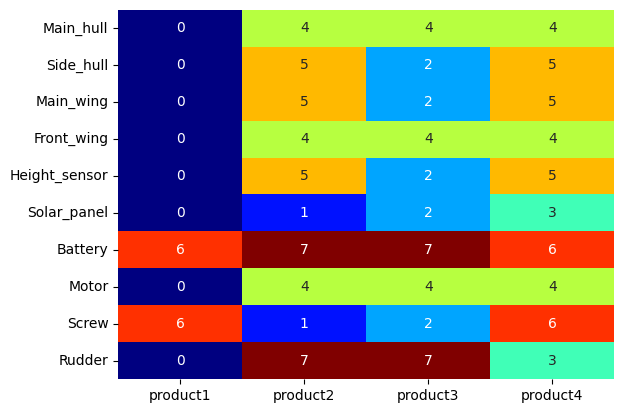

総妥強度: 646.6666666666667 -> 646.6666666666667 -> 0.039657020364415985
構成部位共通化率: 0.43333333333333335 -> 0.43333333333333335 -> 0.31216931216931215
構造共通化率: 0.662962962962963 -> 0.662962962962963 -> 0.21075837742504405
調整阻害度: 12470 -> 12470 -> 1.6335797254487856


In [ ]:
# 0:個別，1:共通として，共通部は１構成部位に対して１つにする方法
# 制約（藤田先生の論文参照）に違反する遺伝子は排除する？


# 共通化される構成部位の組み合わせペアを表示する
def check_common_pair(pf, ga):
    for i, c in enumerate(ga.chromosome):
        if c == 1:
            icp = math.floor(float(i) / math.comb(pf.n_pr, 2))+1
            icmb = i % math.comb(pf.n_pr, 2) + 1
            iprs = cf.comb_index(icmb,pf.n_pr)
            print('構成部位' + str(icp) + ', 製品' + str(iprs[0]) + ' x 製品' + str(iprs[1]))
    return

# 一時的な処置．難しい組み合わせで検証できるようにしている
def sousa(ga):
    #1
    ga.chromosome[0]=1 #1x2
    ga.chromosome[1]=0 #1x3
    ga.chromosome[2]=0 #1x4
    ga.chromosome[3]=0 #2x3
    ga.chromosome[4]=0 #2x4
    ga.chromosome[5]=1 #3x4
    #2
    ga.chromosome[6]=0 #1x2
    ga.chromosome[7]=1 #1x3
    ga.chromosome[8]=0 #1x4
    ga.chromosome[9]=0 #2x3
    ga.chromosome[10]=1 #2x4
    ga.chromosome[11]=1 #3x4
    return

cf = CommonFunctions()
pf = ProductFamily()
pc = 1.0
pm = 0
lmbd = 300
mu = 150

k_tcd = 1#5#10
k_pcr = 1#4000#10
k_scr = 1#500#100#1
k_inh = 1#0.1#0.5

goal_tcd = 622
goal_pcr = 0.63
goal_scr = 0.84
goal_inh =4735

nrep = 100

import time
start = time.perf_counter()
ga = EvolutionaryAlgorithm(pf,pc,pm,lmbd,mu,k_tcd,k_pcr,k_scr,k_inh,goal_tcd,goal_pcr,goal_scr,goal_inh,nrep)
ga.calculation()
print("elapsed_time = {0} sec".format(time.perf_counter()-start))

               product1  product2  product3  product4
Main_hull             2         2         1         2
Side_hull             3         0         1         3
Main_wing             2         2         1         2
Front_wing            2         2         1         2
Height_sensor         4         4         4         4
Solar_panel           2         2         1         2
Battery               2         2         1         2
Motor                 2         2         1         2
Screw                 3         0         1         3
Rudder                2         2         1         2


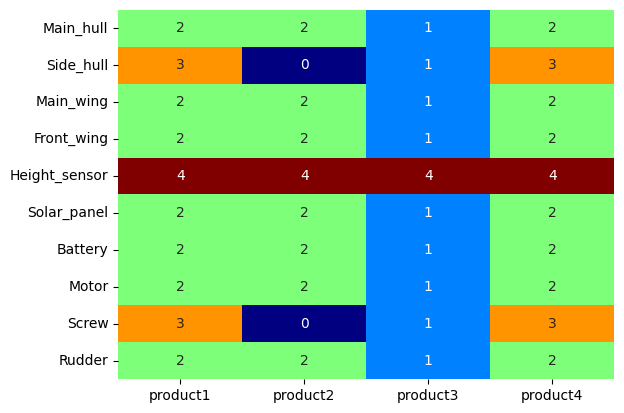

総妥強度: 622.0 -> 622.0 -> 0.0
構成部位共通化率: 0.6333333333333333 -> 0.6333333333333333 -> 0.005291005291005237
構造共通化率: 0.8444444444444444 -> 0.8444444444444444 -> 0.005291005291005325
調整阻害度: 4735 -> 4735 -> 0.4222791605661298


[['Cp2,Pr2', 'Cp9,Pr2'],
 ['Cp1,Pr3',
  'Cp2,Pr3',
  'Cp3,Pr3',
  'Cp4,Pr3',
  'Cp6,Pr3',
  'Cp7,Pr3',
  'Cp8,Pr3',
  'Cp9,Pr3',
  'Cp10,Pr3'],
 ['Cp1,Pr1',
  'Cp1,Pr2',
  'Cp1,Pr4',
  'Cp3,Pr1',
  'Cp3,Pr2',
  'Cp3,Pr4',
  'Cp4,Pr1',
  'Cp4,Pr2',
  'Cp4,Pr4',
  'Cp6,Pr1',
  'Cp6,Pr2',
  'Cp6,Pr4',
  'Cp7,Pr1',
  'Cp7,Pr2',
  'Cp7,Pr4',
  'Cp8,Pr1',
  'Cp8,Pr2',
  'Cp8,Pr4',
  'Cp10,Pr1',
  'Cp10,Pr2',
  'Cp10,Pr4'],
 ['Cp2,Pr1', 'Cp2,Pr4', 'Cp9,Pr1', 'Cp9,Pr4'],
 ['Cp5,Pr1', 'Cp5,Pr2', 'Cp5,Pr3', 'Cp5,Pr4']]

In [43]:

cf = CommonFunctions()
pf = ProductFamily()
g = Gene(pf)

i = 0#Main hull
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 6#Side hull
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 0 #2x4
g.chromosome[i+5] = 0 #3x4
i = 12#MainWing
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 18#front wing
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 24#Height sensor
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 1 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 1 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 1 #3x4
i = 30#solar panel
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 36#battery
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 42#motor
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 48#screw
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 0 #2x4
g.chromosome[i+5] = 0 #3x4
i = 54#rudder
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4

# print(g.chromosome.reshape(10, 6))
g.evaluate(k_tcd,k_pcr,k_scr,k_inh,goal_tcd,goal_pcr,goal_scr,goal_inh)
g.visualize_module_list()
print('総妥強度: ' + str(g.total_compromise_degree) + ' -> ' + str(g.total_compromise_degree*k_tcd) + ' -> ' + str(abs(goal_tcd - g.total_compromise_degree)/goal_tcd * k_tcd))
print('構成部位共通化率: ' + str(g.pcr) + ' -> ' + str(g.pcr*k_pcr) + ' -> ' + str(abs(goal_pcr - g.pcr)/goal_pcr * k_pcr))
print('構造共通化率: ' + str(g.scr) + ' -> ' + str(g.scr*k_scr) + ' -> ' + str(abs(goal_scr-g.scr)/goal_scr * k_scr))
print('調整阻害度: ' + str(g.inh_coord) + ' -> ' + str(g.inh_coord*k_inh) + ' -> ' + str(abs(goal_inh-g.inh_coord)/goal_inh * k_inh))
#####!!!!!調整阻害度だけ結果が異なる！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！

g.modules


               product1  product2  product3  product4
Main_hull             0         2         1         2
Side_hull             0         3         3         3
Main_wing             0         2         1         2
Front_wing            0         2         1         2
Height_sensor         4         4         4         4
Solar_panel           4         4         4         4
Battery               5         5         1         5
Motor                 5         5         1         5
Screw                 0         2         1         2
Rudder                5         5         1         5


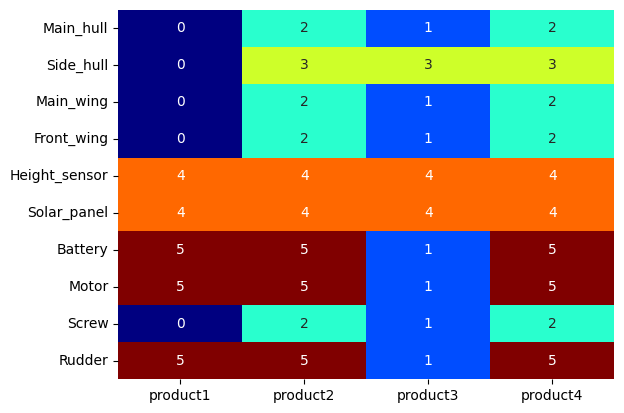

総妥強度: 522.0 -> 522.0 -> 0.1607717041800643
構成部位共通化率: 0.6 -> 0.6 -> 0.04761904761904766
構造共通化率: 0.8222222222222222 -> 0.8222222222222222 -> 0.02116402116402117
調整阻害度: 14314 -> 14314 -> 2.0236586396282212


In [39]:

cf = CommonFunctions()
pf = ProductFamily()
g = Gene(pf)

i = 0#Main hull
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 0 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 6#Side hull
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 0 #1x4
g.chromosome[i+3] = 1 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 1 #3x4
i = 12#MainWing
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 0 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 18#front wing
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 0 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 24#Height sensor
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 1 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 1 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 1 #3x4
i = 30#solar panel
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 1 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 1 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 1 #3x4
i = 36#battery
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 42#motor
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 48#screw
g.chromosome[i+0] = 0 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 0 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4
i = 54#rudder
g.chromosome[i+0] = 1 #1x2
g.chromosome[i+1] = 0 #1x3
g.chromosome[i+2] = 1 #1x4
g.chromosome[i+3] = 0 #2x3
g.chromosome[i+4] = 1 #2x4
g.chromosome[i+5] = 0 #3x4

# print(g.chromosome.reshape(10, 6))
g.evaluate(k_tcd,k_pcr,k_scr,k_inh,goal_tcd,goal_pcr,goal_scr,goal_inh)
g.visualize_module_list()
print('総妥強度: ' + str(g.total_compromise_degree) + ' -> ' + str(g.total_compromise_degree*k_tcd) + ' -> ' + str(abs(goal_tcd - g.total_compromise_degree)/goal_tcd * k_tcd))
print('構成部位共通化率: ' + str(g.pcr) + ' -> ' + str(g.pcr*k_pcr) + ' -> ' + str(abs(goal_pcr - g.pcr)/goal_pcr * k_pcr))
print('構造共通化率: ' + str(g.scr) + ' -> ' + str(g.scr*k_scr) + ' -> ' + str(abs(goal_scr-g.scr)/goal_scr * k_scr))
print('調整阻害度: ' + str(g.inh_coord) + ' -> ' + str(g.inh_coord*k_inh) + ' -> ' + str(abs(goal_inh-g.inh_coord)/goal_inh * k_inh))
#####!!!!!調整阻害度だけ結果が異なる！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！



## 時間計測

In [ ]:
print(ga.time_cross)
print(ga.time_mutation)
print(ga.time_evaluation) # ほとんど評価で時間がかかっている
print(ga.time_selection)

print(ga.time_cdl) #2番
print(ga.time_ccl)
print(ga.time_ml)
print(ga.time_eva1)
print(ga.time_eva2)
print(ga.time_eva3) #1番
print(ga.time_eva4) #3番


0.08872856599998613
0.0420054059998165
31.588769836999063
0.08882647499990526
9.540228873000842
0.038633921998666665
0.18466775999911533
1.3543641610004897
0.03797832899977038
14.247412137999618
6.170130335999943


共通化される構成部位なし
[['Cp1,Pr1', 'Cp2,Pr1', 'Cp3,Pr1', 'Cp4,Pr1', 'Cp5,Pr1', 'Cp6,Pr1', 'Cp7,Pr1', 'Cp8,Pr1', 'Cp9,Pr1', 'Cp10,Pr1'], ['Cp1,Pr2', 'Cp2,Pr2', 'Cp3,Pr2', 'Cp4,Pr2', 'Cp5,Pr2', 'Cp6,Pr2', 'Cp7,Pr2', 'Cp8,Pr2', 'Cp9,Pr2', 'Cp10,Pr2'], ['Cp1,Pr3', 'Cp2,Pr3', 'Cp3,Pr3', 'Cp4,Pr3', 'Cp5,Pr3', 'Cp6,Pr3', 'Cp7,Pr3', 'Cp8,Pr3', 'Cp9,Pr3', 'Cp10,Pr3'], ['Cp1,Pr4', 'Cp2,Pr4', 'Cp3,Pr4', 'Cp4,Pr4', 'Cp5,Pr4', 'Cp6,Pr4', 'Cp7,Pr4', 'Cp8,Pr4', 'Cp9,Pr4', 'Cp10,Pr4']]
               product1  product2  product3  product4
Main_hull             0         1         2         3
Side_hull             0         1         2         3
Main_wing             0         1         2         3
Front_wing            0         1         2         3
Height_sensor         0         1         2         3
Solar_panel           0         1         2         3
Battery               0         1         2         3
Motor                 0         1         2         3
Screw                 0         1         2     

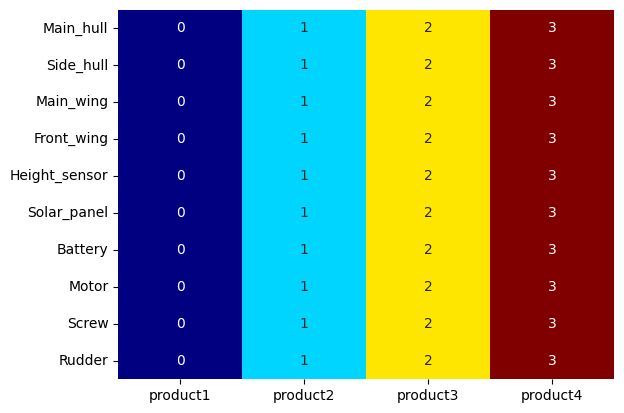

総妥強度: 0.0
構成部位共通化率: 0.0
構造共通化率: 1.0
調整阻害度: 0


In [ ]:
pf = ProductFamily()
g = Gene(pf)
for i in range(len(g.chromosome)):
    g.chromosome[i] = 0

g.evaluate(1,1,1,1)
print(g.modules)
g.visualize_module_list()
print('総妥強度: ' + str(g.total_compromise_degree))
print('構成部位共通化率: ' + str(g.pcr))
print('構造共通化率: ' + str(g.scr))
print('調整阻害度: ' + str(g.inh_coord))
